In [70]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [71]:
Data = pd.read_csv("./Result_data.csv")
Data.head()

,EMD_CD,DMCLS_CD_wmode,AGCLS_CD_wmode,frtp_avg,dnst_avg,Area,geometry,mtn_area,Mtn_Ratio,human_adj_area,human_mtn_Ratio,human_Total_Ratio,ctr_mean,ctr_std,n_ctrs,Fire_Count
0,11110101,23,4,0.125,0.6,792617.902967,POLYGON ((953700.0221347539 1954605.0654306228...,67529.485826,0.085198,36117.996122,0.534848,0.045568,173.809524,73.940935,21,0
1,11110102,23,4,0.125,0.6,98821.715201,POLYGON ((953233.4654317541 1953996.9839332262...,59869.101208,0.605829,40495.878201,0.676407,0.409787,87.500000,32.274861,4,0
2,11110103,23,4,0.125,0.6,73271.654659,POLYGON ((953560.2281430522 1954257.4664824517...,776.906691,0.010603,0.000000,0.000000,0.000000,50.000000,0.000000,1,0
3,11110109,23,4,0.125,0.6,258561.672009,POLYGON ((952981.2076348594 1953604.3112467206...,79017.474842,0.305604,77079.210797,0.975470,0.298108,160.000000,71.879529,10,0
4,11110111,23,4,0.125,0.6,417438.349374,"POLYGON ((952769.057857475 1954155.9539321065,...",113433.905865,0.271738,113433.905865,1.000000,0.271738,187.500000,84.210131,14,0


#### Stacking Ensemble 기법 모델링

In [72]:
Features_bin = Data.copy()
Features_bin.Fire_Count = (Features_bin.Fire_Count>0).astype(int)
Target_bin = Features_bin.Fire_Count
#Features_bin.drop(columns=["Fire_Count", "geometry", "EMD_CD", "mtn_area", "human_adj_area"], inplace = True)
#면적 관련 정보 제거 옵션
Features_bin.drop(columns=["Fire_Count", "geometry", "EMD_CD", "Area", "mtn_area", "human_adj_area", "n_ctrs"], inplace = True)
Features_bin

,DMCLS_CD_wmode,AGCLS_CD_wmode,frtp_avg,dnst_avg,Mtn_Ratio,human_mtn_Ratio,human_Total_Ratio,ctr_mean,ctr_std
0,23,4,0.125000,0.600000,0.085198,0.534848,0.045568,173.809524,73.940935
1,23,4,0.125000,0.600000,0.605829,0.676407,0.409787,87.500000,32.274861
2,23,4,0.125000,0.600000,0.010603,0.000000,0.000000,50.000000,0.000000
3,23,4,0.125000,0.600000,0.305604,0.975470,0.298108,160.000000,71.879529
4,23,4,0.125000,0.600000,0.271738,1.000000,0.271738,187.500000,84.210131
...,...,...,...,...,...,...,...,...,...
3998,23,5,0.350721,0.838103,0.899488,0.211161,0.189937,660.853909,344.959650
3999,23,4,0.845896,0.829818,0.536337,0.173697,0.093160,97.925764,63.163660
4000,23,5,0.508427,0.828935,0.856081,0.250085,0.214093,369.624682,289.702053
4001,23,4,0.723005,0.791727,0.721694,0.294532,0.212562,199.795082,213.608011


In [73]:
features_train, features_test, target_train, target_test = train_test_split(Features_bin, Target_bin, test_size=0.2, stratify=Target_bin, random_state=42)
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [74]:
svm_model = SVC(C= 1, kernel = "rbf", class_weight='balanced', probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators = 100, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth = 3, scale_pos_weight=3, random_state=42)

In [75]:
stacking = StackingClassifier(
    estimators=[
        ('svm', svm_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=5,  # internal cross-validation to generate meta-features
    n_jobs=-1
)

In [76]:
stacking.fit(features_train_scaled, target_train)

StackingClassifier(cv=5,
                   estimators=[('svm',
                                SVC(C=1, class_weight='balanced',
                                    probability=True, random_state=42)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=Non...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=1000),
                   n_jobs=-1)

In [77]:
target_pred = stacking.predict(features_test_scaled)

In [78]:
print(confusion_matrix(target_test, target_pred))
print(classification_report(target_test, target_pred))

[[410 204]
 [ 41 146]]
              precision    recall  f1-score   support

           0       0.91      0.67      0.77       614
           1       0.42      0.78      0.54       187

    accuracy                           0.69       801
   macro avg       0.66      0.72      0.66       801
weighted avg       0.79      0.69      0.72       801



#### 각 읍면동마다 예측된 산불 위험 수치 출력

In [79]:
# 읍면동 경계 불러오기 
import geopandas as gpd

emd = gpd.read_file(f"./emd/emd.shp", encoding="euc-kr")
emd.set_crs(epsg=5179, inplace=True)

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((953700.022 1954605.065, 953693.871 1..."
1,11110102,Singyo-dong,신교동,"POLYGON ((953233.465 1953996.984, 953235.183 1..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((953560.228 1954257.466, 953561.19 19..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((953519.843 1953890.785, 953518.489 1..."
4,11110105,Changseong-dong,창성동,"POLYGON ((953516.123 1953734.362, 953516.526 1..."
...,...,...,...,...
5060,51830310,Seo-myeon,서면,"POLYGON ((1079287.552 2011045.57, 1079356.15 2..."
5061,51830320,Sonyang-myeon,손양면,"MULTIPOLYGON (((1102997.769 2009910.288, 11029..."
5062,51830330,Hyeonbuk-myeon,현북면,"MULTIPOLYGON (((1108475.024 2002913.557, 11084..."
5063,51830340,Hyeonnam-myeon,현남면,"MULTIPOLYGON (((1114466.017 1992227.421, 11145..."


In [80]:
Data.drop(columns=['geometry','Fire_Count',"EMD_CD", "mtn_area", "human_adj_area","Area", "n_ctrs"])

,DMCLS_CD_wmode,AGCLS_CD_wmode,frtp_avg,dnst_avg,Mtn_Ratio,human_mtn_Ratio,human_Total_Ratio,ctr_mean,ctr_std
0,23,4,0.125000,0.600000,0.085198,0.534848,0.045568,173.809524,73.940935
1,23,4,0.125000,0.600000,0.605829,0.676407,0.409787,87.500000,32.274861
2,23,4,0.125000,0.600000,0.010603,0.000000,0.000000,50.000000,0.000000
3,23,4,0.125000,0.600000,0.305604,0.975470,0.298108,160.000000,71.879529
4,23,4,0.125000,0.600000,0.271738,1.000000,0.271738,187.500000,84.210131
...,...,...,...,...,...,...,...,...,...
3998,23,5,0.350721,0.838103,0.899488,0.211161,0.189937,660.853909,344.959650
3999,23,4,0.845896,0.829818,0.536337,0.173697,0.093160,97.925764,63.163660
4000,23,5,0.508427,0.828935,0.856081,0.250085,0.214093,369.624682,289.702053
4001,23,4,0.723005,0.791727,0.721694,0.294532,0.212562,199.795082,213.608011


In [81]:
Data_scaled = scaler.transform(Data.drop(columns=['geometry','Fire_Count',"EMD_CD", "mtn_area", "human_adj_area","Area", "n_ctrs"]))
Data["predicted"] = stacking.predict_proba(Data_scaled)[:,1]
Data.predicted = Data.predicted*100


In [82]:
emd.EMD_CD = emd.EMD_CD.apply(int)

In [83]:
emd = emd.merge(Data[["EMD_CD", "predicted"]])

<Axes: >

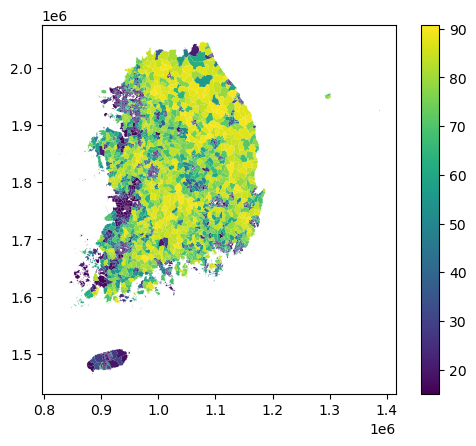

In [84]:
emd.plot(column="predicted", legend=True)

In [85]:
prob_by_emd = pd.DataFrame(emd.drop(columns=["geometry"]))

In [86]:
prob_by_emd

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,predicted
0,11110101,Cheongun-dong,청운동,17.431123
1,11110102,Singyo-dong,신교동,16.402082
2,11110103,Gungjeong-dong,궁정동,15.002155
3,11110109,Nusang-dong,누상동,22.543837
4,11110111,Ogin-dong,옥인동,26.717246
...,...,...,...,...
3998,51830310,Seo-myeon,서면,84.840854
3999,51830320,Sonyang-myeon,손양면,47.417731
4000,51830330,Hyeonbuk-myeon,현북면,85.962423
4001,51830340,Hyeonnam-myeon,현남면,78.025756


In [87]:
prob_by_emd.to_csv("Fire_Prob_EMD.csv")